In [1]:
## anaconda3 (Python 3.12.0) Kernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [2]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_63657/3199335484.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


In [3]:
len(pairsOutcome)

17

# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [4]:
import csv

with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]


top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]

tot = 0
print("17 clustered pair trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Value: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")
    tot += pairsOutcome[key].cumpnl.iloc[-2]

tot/len(top_keys)


17 clustered pair trades:
1. Key: 6503 JP Equity 7269 JP Equity, Value: 1.33
2. Key: 6326 JP Equity 6954 JP Equity, Value: 1.19
3. Key: 8053 JP Equity 8058 JP Equity, Value: 0.52
4. Key: 4901 JP Equity 9613 JP Equity, Value: 1.10
5. Key: 6988 JP Equity 7267 JP Equity, Value: 0.65
6. Key: 4901 JP Equity 6702 JP Equity, Value: -0.34
7. Key: 4684 JP Equity 7832 JP Equity, Value: 0.89
8. Key: 7267 JP Equity 8306 JP Equity, Value: 1.16
9. Key: 7267 JP Equity 8801 JP Equity, Value: 0.64
10. Key: 4519 JP Equity 7532 JP Equity, Value: 1.14


0.8286735764233203

## Calculate baseline Pair Trade Portfolio Returns

Assume that each pair  and there is no diversification of returns. Each Pair Trade is self-funded and only has risk of 10% of initial investment (1 unit).

2013 is used as warm up year to consolidate rolling window aggregate mid and Std dev data. Investment only starts from 2014.

In [5]:
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]

df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
df_daily_returns.cumsum()

,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl
Date,,,,,,,,,,
1/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7/1/2013,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
27/5/2024,1.308067,1.19382,0.518366,1.083350,0.645342,-0.338771,0.886695,1.173548,0.644275,1.13833
28/5/2024,1.343141,1.19382,0.518366,1.086770,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833
29/5/2024,1.371096,1.19382,0.518366,1.090710,0.645342,-0.338771,0.886695,1.162874,0.644275,1.13833


## Baseline graph

Investing starts from 2014 as a warm start for 1 year rolling window (from 2013) we plot the total returns.

In [6]:
df_port_return = df_daily_returns.cumsum().sum(axis=1)/10
np.exp(df_port_return).describe()

count    2979.000000
mean        1.288108
std         0.348571
min         0.918642
25%         1.006095
50%         1.146149
75%         1.498417
max         2.296241
dtype: float64

Text(0.5, 1.0, 'Baseline returns')

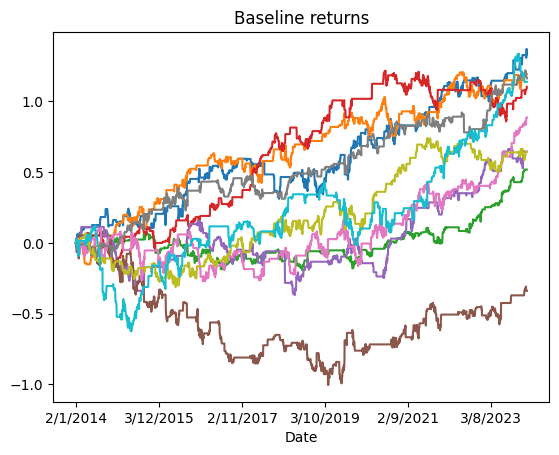

In [7]:
df_daily_returns.cumsum()[262:-1].plot(legend=None)
plt.title("Baseline returns")

In [8]:
postion_data = [pairsOutcome[key]['position'] for key in top_keys]

pd.DataFrame(postion_data).T.abs().sum(axis=1).describe()

count    2979.000000
mean        3.422625
std         1.826316
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         9.000000
dtype: float64

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and process each CSV
baseline_ret = pd.read_csv("31_baseline_return.csv")
baseline_ret.set_index('Date', inplace=True)
baseline_ret.rename(columns={'0': 'Baseline'}, inplace=True)

nobellman_ret = pd.read_csv("32_nobellman_return.csv")
nobellman_ret.set_index('Date', inplace=True)
nobellman_ret.rename(columns={'0': 'NoBellman'}, inplace=True)

gamma0_ret = pd.read_csv("33_bellman_gamma0_return.csv")
gamma0_ret.set_index('Date', inplace=True)
gamma0_ret.rename(columns={'0': 'Gamma0'}, inplace=True)

bellman_ret = pd.read_csv("34_bellman_gamma001_return.csv")
bellman_ret.set_index('Date', inplace=True)
bellman_ret.rename(columns={'0': 'Gamma001'}, inplace=True)

dqn_ret = pd.read_csv("35_DQN_return.csv")
dqn_ret.set_index('Date', inplace=True)
dqn_ret.rename(columns={'0': 'DQN'}, inplace=True)

df = pd.concat([baseline_ret, nobellman_ret, gamma0_ret, bellman_ret,dqn_ret], axis=1)[261:]




In [14]:
df

,Baseline,NoBellman,Gamma0,Gamma001,DQN
Date,,,,,
2014-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-03,-0.004004,-0.001992,-0.002840,-0.003876,-0.001301
2014-01-06,0.000957,0.004330,0.003457,0.001797,0.001925
2014-01-07,0.003407,0.007727,0.006488,0.003910,0.005321
...,...,...,...,...,...
2024-05-27,0.825302,1.822203,1.578004,1.582649,1.722585
2024-05-28,0.828084,1.823157,1.580309,1.584336,1.720031
2024-05-29,0.831274,1.827282,1.583993,1.588655,1.724157


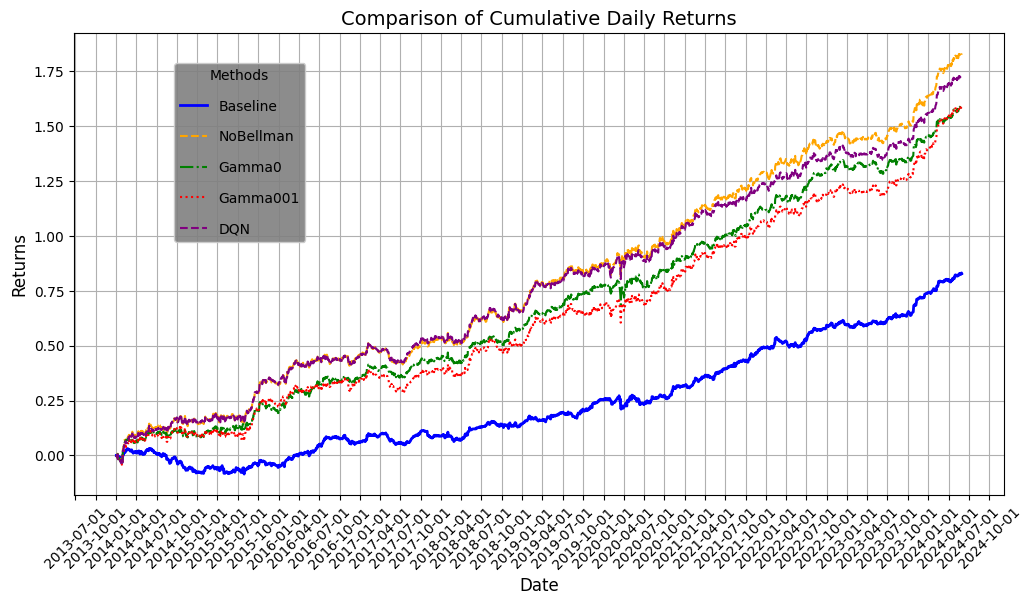

In [28]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Baseline'], label='Baseline', linewidth=2, linestyle='-', color='blue')
plt.plot(df.index, df['NoBellman'], label='NoBellman', linewidth=1.5, linestyle='--', color='orange')
plt.plot(df.index, df['Gamma0'], label='Gamma0', linewidth=1.5, linestyle='-.', color='green')
plt.plot(df.index, df['Gamma001'], label='Gamma001', linewidth=1.5, linestyle=':', color='red')
plt.plot(df.index, df['DQN'], label='DQN', linewidth=1.5, linestyle='--', color='purple')

# Add titles, labels, legend, and grid
plt.title("Comparison of Cumulative Daily Returns", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.legend(title="Methods", fontsize=10, labelspacing=1.2, loc='upper left', bbox_to_anchor=(0.1, 0.95), framealpha=0.9, facecolor='grey')
plt.grid()

# Ensure index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Set quarterly ticks using MonthLocator with intervals of 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, fontsize=10)

plt.show()
